In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

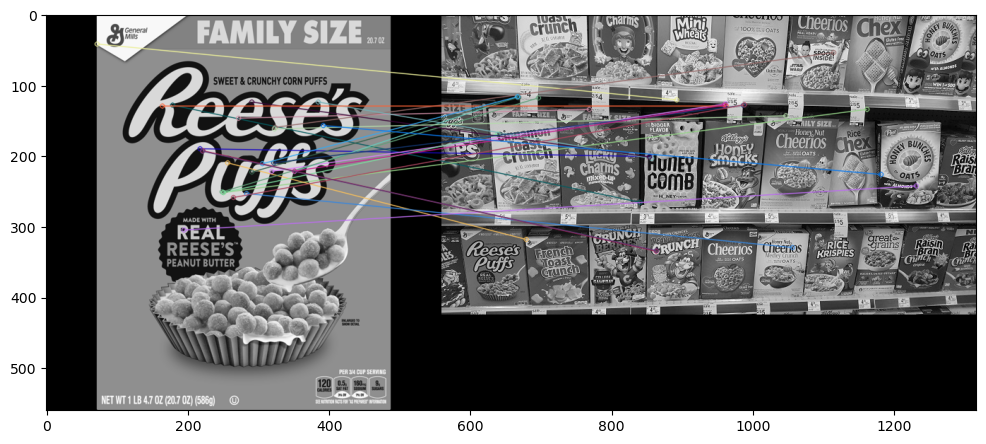

In [6]:
cereal = cv2.imread("DATA/reeses_puffs.png", 0)
many_cereal = cv2.imread("DATA/many_cereals.jpg", 0)

def display(img, cmap="gray"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(cereal, None) # None is mask
kp2, des2 = orb.detectAndCompute(many_cereal, None)

# brute force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = bf.match(des1, des2) # match descriptors

# each element in matches is a DMatch object
# the likely the match, the smaller the distance
# hence, so we sort by distance

matches = sorted(matches, key=lambda x: x.distance) # sort matches by distance

# draw the first 25 matches - provide keypoints and matches
cereal_matches = cv2.drawMatches(cereal, kp1, many_cereal, kp2, matches[:25], None, flags=2)

display(cereal_matches) # we can observe that brute force is not very good

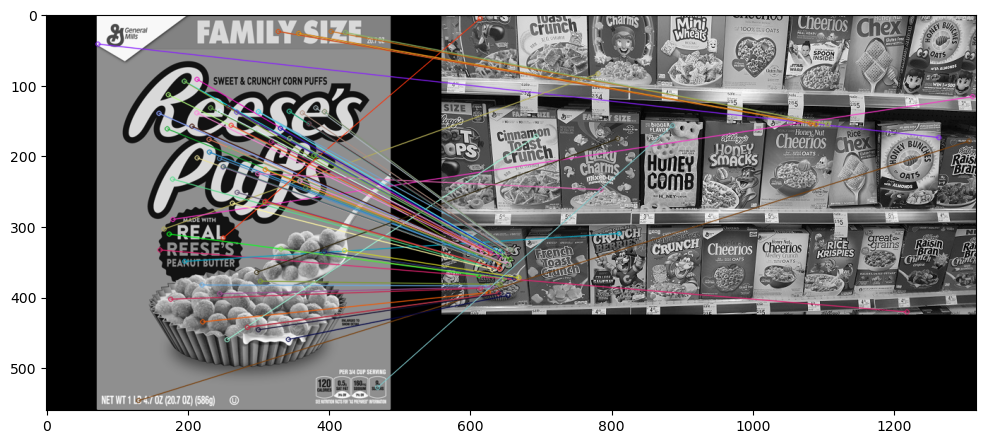

In [10]:
sift = cv2.xfeatures2d.SIFT_create() # create a SIFT object

# keypoint and descriptors
kp1, des1 = sift.detectAndCompute(cereal, None)
kp2, des2 = sift.detectAndCompute(many_cereal, None)

bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)

# knnMatch takes in two descriptors and returns a list of matches

# matches is a list of lists where each sublist contains two DMatch objects.

# the key idea is to compare the distance of the first DMatch object with the second - the closer the better the match.

good_matches = []

for match1, match2 in matches:
    # ratio test - for similar distances.
    if match1.distance < 0.75 * match2.distance: # similar descriptors.
        good_matches.append([match1])

sift_matches = cv2.drawMatchesKnn(cereal, kp1, many_cereal, kp2, good_matches, None, flags=2)

display(sift_matches)

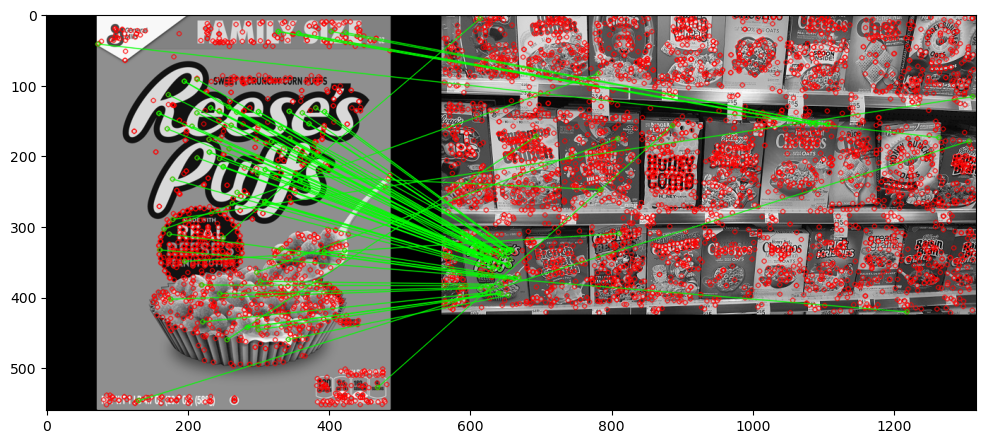

In [16]:
# Flann base matcher - much faster than brute force but less accurate

sift = cv2.xfeatures2d.SIFT_create() # create a SIFT object - same as the bfm using knnMatch. (k nearest neighbors)

# keypoint and descriptors
kp1, des1 = sift.detectAndCompute(cereal, None)
kp2, des2 = sift.detectAndCompute(many_cereal, None)

# FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # trees is the number of trees to use in the algorithm

search_params = dict(checks=50) # number of times the trees in the index should be recursively traversed

flann = cv2.FlannBasedMatcher(index_params, search_params) 
matches = flann.knnMatch(des1, des2, k=2)
matchesMask = [[0, 0] for i in range(len(matches))] # create a mask - turn some elements to 1 if we have a good match


for i, (match1, match2) in enumerate(matches):
    # ratio test - for similar distances.
    if match1.distance < 0.75 * match2.distance: # similar descriptors.
        matchesMask[i] = [1, 0] # a good match - show

# drawing parameters to alter how we show the matches
draw_params = dict(matchColor=(0, 255, 0), singlePointColor = (255,0,0), matchesMask = matchesMask)

# green for good matches
# red for single points

# drawing matches
flann_matches = cv2.drawMatchesKnn(cereal, kp1, many_cereal, kp2, matches, None, **draw_params)

display(flann_matches)